In [1]:
import numpy as np
import pandas as pd
import pathlib
from tqdm.notebook import tqdm
import torch

In [2]:
base_path = "/home/jakobs"

In [3]:
endpoints_md = pd.read_csv(f"{base_path}/BiHealth/onnx/endpoints.csv").drop(columns="Unnamed: 0").set_index("endpoint")#[["endpoint", "eligable", "n", "freq", "phecode", "phecode_string", "phecode_category", "sex"]]
endpoints_md

,eligable,n,freq,phecode_string,phecode_category
endpoint,,,,,
OMOP_4306655,61213,3471,0.056704,Death,Event
phecode_002,61005,535,0.008770,Staphylococcus,ID
phecode_002-1,61066,354,0.005797,Staphylococcus aureus,ID
phecode_003,61095,703,0.011507,Escherichia coli,ID
phecode_004,61049,354,0.005799,Streptococcus,ID
...,...,...,...,...,...
phecode_981,60297,1966,0.032605,Family history of malignant neoplasm,Stat
phecode_983,61178,125,0.002043,Family history of other endocrine and metaboli...,Stat
phecode_988,60364,2422,0.040123,Family history of cardiovascular disease,Stat


In [4]:
# @JAKOB: If loading the hydra config is a problem I've also put the actual
# params in the comments so you don't necessarily have to use hydra. 

import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()

hydra.initialize(config_path="../../RetinalRisk/config")

covariates = "no_covariates"
num_hidden = 256

cfg = hydra.compose(
    config_name="config",
    overrides=[
        "training.gradient_checkpointing=False",
        f"datamodule/covariates={covariates}",
        "datamodule.partition=20",
        "model=retfound",
        "model.retfound_augment=True",
        "setup.use_data_artifact_if_available=False",
        "head=mlp",
        f"head.kwargs.num_hidden={num_hidden}",
        "head.kwargs.num_layers=2",
        "head.dropout=0",
        "training.optimizer_kwargs.weight_decay=0.001",
        "training.optimizer_kwargs.lr=0.0001",
        "model.freeze_encoder=False",
        "datamodule.batch_size=32",
        "training.warmup_period=8",
        "datamodule/augmentation=contrast_sharpness_posterize",
        "datamodule.img_size_to_gpu=224",
        "datamodule.num_workers=32",
        "model.pretrained=True",
    ],
)

/tmp/ipykernel_71332/2798915319.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../../RetinalRisk/config")


In [5]:
from retinalrisk.models.retfound import vit_large_patch16, interpolate_pos_embed
from timm.models.layers import trunc_normal_

def setup_retfound_model(args):
    checkpoint_path = args.model.checkpoint_path

    image_size = args.datamodule.augmentation.train.CenterCrop.size

    model = vit_large_patch16(
        num_classes=2,
        drop_path_rate=args.model.drop_path_rate,
        global_pool=True,
        img_size=image_size,
    )

    if args.model.pretrained:
        # load RETFound weights
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        checkpoint_model = checkpoint["model"]
        state_dict = model.state_dict()
        for k in ["head.weight", "head.bias"]:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        # interpolate position embedding
        interpolate_pos_embed(model, checkpoint_model)

        # load pre-trained model
        msg = model.load_state_dict(checkpoint_model, strict=False)

        assert set(msg.missing_keys) == {
            "head.weight",
            "head.bias",
            "fc_norm.weight",
            "fc_norm.bias",
        }

    # manually initialize fc layer
    trunc_normal_(model.head.weight, std=2e-5)

    encoder = model
    encoder.head = torch.nn.Identity()

    outshape = 1024

    return encoder, outshape

In [6]:
import math
import warnings
from socket import gethostname

import numpy as np
import torch
import torchvision as tv
import torchmetrics

from retinalrisk.models.supervised import (
    ImageTraining
)
from retinalrisk.modules.head import MLPHead

def setup_training():
    
    def get_head(num_head_features, num_endpoints):

        cls = MLPHead

        return cls(
            num_head_features,
            num_endpoints,
            incidence=None,
            dropout=cfg.head.dropout, # 0
            gradient_checkpointing=False,
            num_hidden = cfg.head.kwargs.num_hidden, # 256
            num_layers = cfg.head.kwargs.num_layers, # 2
        )
    
    # base_path = "/home/jakobs"
    x = torch.load(f"{base_path}/BiHealth/ckpts_RetFound/4.ckpt", map_location=torch.device('cpu'))
    #x = torch.load('/sc-projects/sc-proj-ukb-cvd/results/models/retina/2cpw9zcx/checkpoints/epoch=67-step=13464.ckpt', map_location=torch.device('cpu'))
    
    losses = x['hyper_parameters']["losses"]
    label_mapping = x['hyper_parameters']["label_mapping"]
    incidence_mapping = x['hyper_parameters']["incidence_mapping"]

    cfg.model.checkpoint_path = f"{base_path}/BiHealth/ckpts_RetFound/RETFound_cfp_weights.pth"
    encoder, outshape = setup_retfound_model(cfg)

    head = get_head(num_head_features = outshape, num_endpoints = 773)

    model = ImageTraining(encoder=encoder, head=head, losses=losses, label_mapping=label_mapping, incidence_mapping=None, metrics_list=[], task="tte")

    return model

In [7]:
model = setup_training()

In [8]:
import torch.nn as nn
import PIL
from typing import Union
from random import choice
import torchvision as tv
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

import torch
import torchvision.transforms as transforms
from skimage.io import imread

from timm.data.transforms import RandomResizedCropAndInterpolation

img_size_to_gpu = cfg.datamodule.augmentation.train.CenterCrop.size # 256

transform = transforms.Compose(
    [
        RandomResizedCropAndInterpolation(
            size=(img_size_to_gpu, img_size_to_gpu),
            scale=(0.08, 1.0),
            ratio=(1, 1),
            interpolation="bicubic",
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

from dataclasses import dataclass

import torch

@dataclass
class Batch:
    data: torch.Tensor
    covariates: torch.Tensor
    names: list

## Debug

### Inference itself okay?

In [29]:
import pickle

ckpt = torch.load(f'{base_path}/BiHealth/ckpts_RetFound/4.ckpt', map_location='cpu')
model.load_state_dict(ckpt["state_dict"])
model.eval();
model.to("cuda")

batch_hpc = pickle.load(open(f'{base_path}/data/epic_debug/batch.pkl', 'rb'))
loghs_hpc = pickle.load(open(f'{base_path}/data/epic_debug/loghs.pkl', 'rb'))

with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    loghs_epic1 = predict_batch(model, batch_hpc)

assert torch.allclose(torch.tensor(loghs_hpc).float(), torch.tensor(loghs_epic1).float(), atol=1e-2)

### Data loading okay?

In [30]:
from torch.utils.data import Dataset, DataLoader

class DebugImagesDataset(Dataset):
    def __init__(self, data_images, transform):
        self.data_images = data_images
        self.transform = transform

    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, index):
        img_name = self.data_images.iloc[index]["distfilename"]

        #try:
        img_np = imread(f"{base_path}/data/epic_debug/{img_name}")
        #except:
            #img_np = imread(f"{base_path}/BiHealth/Data/EPICImages_PoorQuality/{img_name}")

        img_pil = PIL.Image.fromarray(img_np)

        try:
            img_tensor = self.transform(img_pil)
        except:
            print(img_name)

        return img_name, img_tensor

def collate_fn(batch):
    img_names, img_tensors = zip(*batch)
    img_names = list(img_names)
    img_tensors = torch.stack(img_tensors)

    return Batch(img_tensors, None, img_names)

def predict_batch(model, img_batch):
    loghs = model(img_batch)["head_outputs"]["logits"].detach().cpu().numpy()
    return loghs

corrupted_files = ["0AIULA8E31FVNEXW_epiceye07142.png", 
                   "0AIULA8E315UZ3KA_epiceye03519.png", 
                   "0AIULA8E3354WXMB_epiceye03739.png",
                   "0AIULA8E32JU9I3E_epiceye00148.png",
                   "0AIULA8E3354JOZ0_epiceye06941.png",
                  "0AIULA8E315XYVCL_epiceye05788.png",
                   "0AIULA8E315WMUA2_epiceye05000.png",
                  "0AIULA8E32JRQLLF_epiceye01039.png",
                  "0AIULA8E329S6BCD_epiceye02546.png",
                  "0AIULA8E31RCZB57_epiceye00155.png",
                  "0AIULA8E31REEET3_epiceye05711.png",
                   "0AIULA8E32SJJSL9_epiceye03063.png",
                  "0AIULA8E31FQZ4OO_epiceye06657.png",
                   "0AIULA8E1HIF7IFB_epiceye05427.png",
                  "0AIULA8E32SDCBXM_epiceye00289.png",
                  "0AIULA8E1KEKKV8Y_epiceye05179.png"]

#data_images = pd.read_stata(f"{base_path}/BiHealth/Data/StudyData/BiHealth_20230313_Long.dta").query("distfilename!=@corrupted_files")

import os
import pandas as pd

# Path to the directory containing PNG images
folder_path = f'{base_path}/data/epic_debug/'

# List to hold image file names
image_files = ['4307603_21015_0_0.png',
 '3507617_21016_0_0.png',
 '5566470_21015_1_0.png',
 '4321401_21015_1_0.png',
 '5080740_21016_0_0.png',
 '1899794_21015_0_0.png',
 '3728190_21016_0_0.png',
 '3667567_21016_1_0.png',
 '3298799_21016_0_0.png',
 '5293867_21015_0_0.png']

# Create a DataFrame with the image file names
data_images = pd.DataFrame(image_files, columns=['distfilename'])
data_images

dataset = DebugImagesDataset(data_images, transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=10, collate_fn=collate_fn, drop_last=False)

In [31]:
batch_epic = next(iter(dataloader))

In [32]:
import matplotlib.pyplot as plt
import torch

def plot_batch(batch):
    # Assuming batch_epic.data is your tensor
    # Convert it to numpy and transpose the axes for plotting
    # From (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = batch.data.cpu().numpy().transpose(0, 2, 3, 1)

    # Normalization parameters
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Reverse the normalization process
    images = std * images + mean
    images = np.clip(images, 0, 1)  # Ensuring the pixel values are in [0, 1]

    # Set the number of images you want to display per row
    images_per_row = 5

    # Calculate the number of rows needed
    num_rows = len(images) // images_per_row + int(len(images) % images_per_row > 0)

    # Create a figure with subplots
    plt.figure(figsize=(20, 4 * num_rows))
    for i, img in enumerate(images, 1):
        plt.subplot(num_rows, images_per_row, i)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

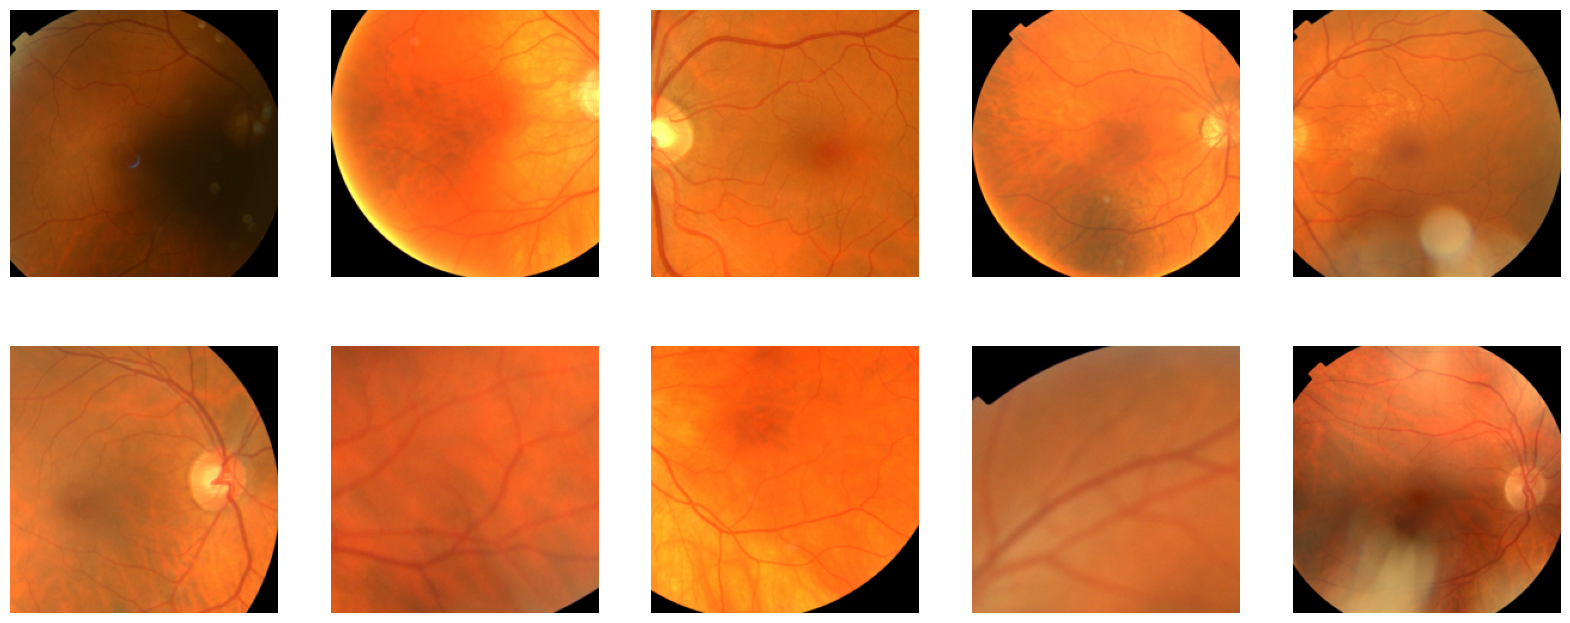

In [33]:
plot_batch(batch_epic)

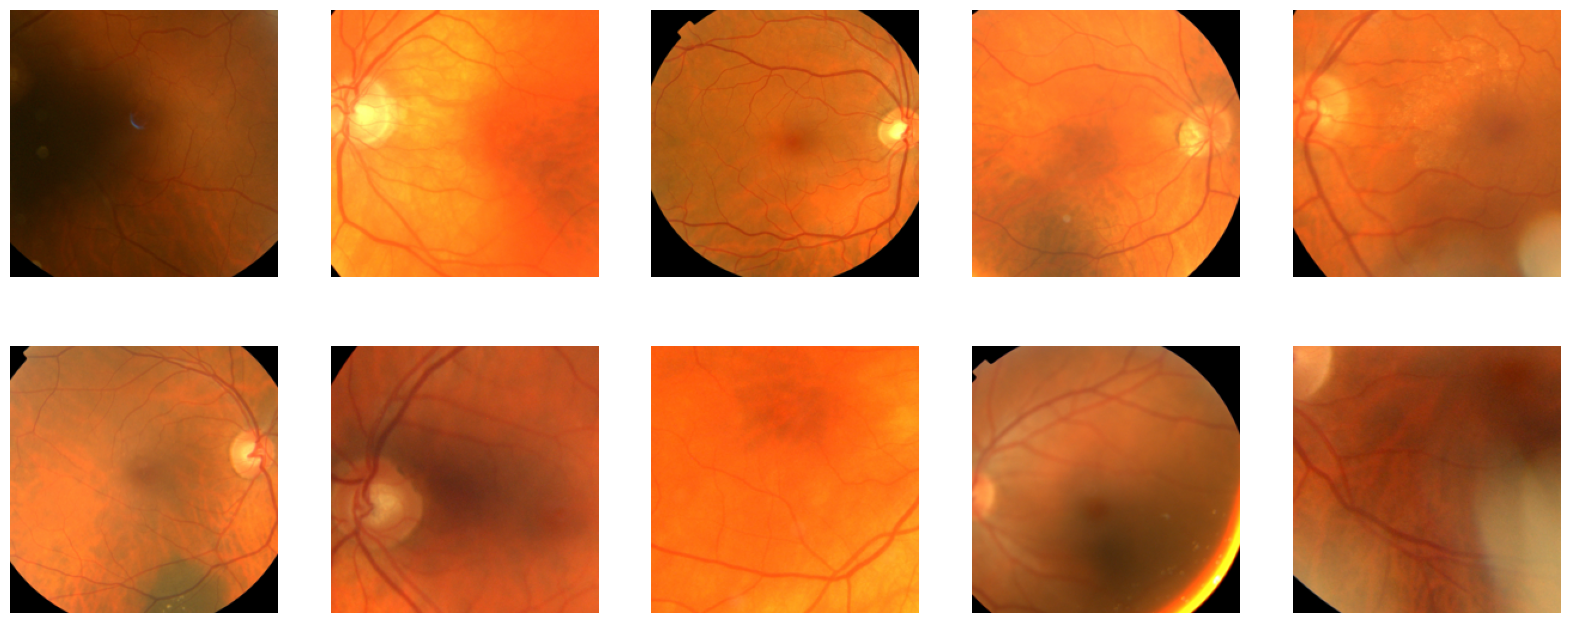

In [34]:
plot_batch(batch_hpc)

### Data loading & inference okay?

In [35]:
import pickle

ckpt = torch.load(f'{base_path}/BiHealth/ckpts_RetFound/4.ckpt', map_location='cpu')
model.load_state_dict(ckpt["state_dict"])
model.eval();
model.to("cuda")

with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    batch_epic.data = batch_epic.data.to("cuda")
    loghs_epic2 = predict_batch(model, batch_epic)

assert torch.allclose(torch.tensor(loghs_hpc).float(), torch.tensor(loghs_epic2).float(), atol=1e-2)

/home/jakobs/.conda/envs/python310/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


AssertionError: 

In [36]:
torch.tensor(loghs_hpc)

tensor([[-6.2617, -4.9297, -4.6875,  ..., -2.6641, -0.5303, -3.6367],
        [-5.2344, -3.7012, -3.5547,  ..., -2.3242, -0.5957, -3.1719],
        [-6.3047, -4.7461, -4.4922,  ..., -2.5430, -0.4377, -4.0352],
        ...,
        [-5.1758, -3.5703, -3.4336,  ..., -2.3008, -0.4194, -3.0156],
        [-7.3750, -5.1953, -4.9297,  ..., -2.9531,  0.5747, -4.9453],
        [-4.4844, -2.5195, -2.2695,  ..., -2.0801, -0.1899, -3.4961]],
       dtype=torch.float16)

In [37]:
torch.tensor(loghs_epic2)

tensor([[-6.3594, -5.0078, -4.7578,  ..., -2.6895, -0.5332, -3.8770],
        [-5.5703, -4.0625, -3.8906,  ..., -2.4414, -0.6572, -3.4219],
        [-6.2266, -4.6836, -4.4219,  ..., -2.5527, -0.4705, -4.1133],
        ...,
        [-5.2852, -3.6035, -3.4688,  ..., -2.3398, -0.4058, -2.9766],
        [-7.1641, -5.2578, -4.9766,  ..., -2.9004,  0.2396, -4.6797],
        [-4.1016, -1.8535, -1.6963,  ..., -1.9922, -0.3560, -2.7812]],
       dtype=torch.float16)

## Inference

In [38]:
import pathlib

In [39]:
from torch.utils.data import Dataset, DataLoader

class EPICImagesDataset(Dataset):
    def __init__(self, data_images, transform):
        self.data_images = data_images
        self.transform = transform

    def __len__(self):
        return len(self.data_images)

    def __getitem__(self, index):
        img_name = self.data_images.iloc[index]["distfilename"]

        try:
            img_np = imread(f"{base_path}/BiHealth/Data/EPICImages/{img_name}")
        except:
            img_np = imread(f"{base_path}/BiHealth/Data/EPICImages_PoorQuality/{img_name}")

        img_pil = PIL.Image.fromarray(img_np)

        try:
            img_tensor = self.transform(img_pil)
        except:
            print(img_name)

        return img_name, img_tensor

def collate_fn(batch):
    img_names, img_tensors = zip(*batch)
    img_names = list(img_names)
    img_tensors = torch.stack(img_tensors)

    return Batch(img_tensors, None, img_names)

def predict_batch(model, img_batch):
    loghs = model(img_batch)["head_outputs"]["logits"].detach().cpu().numpy()
    return loghs

corrupted_files = ["0AIULA8E31FVNEXW_epiceye07142.png", 
                   "0AIULA8E315UZ3KA_epiceye03519.png", 
                   "0AIULA8E3354WXMB_epiceye03739.png",
                   "0AIULA8E32JU9I3E_epiceye00148.png",
                   "0AIULA8E3354JOZ0_epiceye06941.png",
                  "0AIULA8E315XYVCL_epiceye05788.png",
                   "0AIULA8E315WMUA2_epiceye05000.png",
                  "0AIULA8E32JRQLLF_epiceye01039.png",
                  "0AIULA8E329S6BCD_epiceye02546.png",
                  "0AIULA8E31RCZB57_epiceye00155.png",
                  "0AIULA8E31REEET3_epiceye05711.png",
                   "0AIULA8E32SJJSL9_epiceye03063.png",
                  "0AIULA8E31FQZ4OO_epiceye06657.png",
                   "0AIULA8E1HIF7IFB_epiceye05427.png",
                  "0AIULA8E32SDCBXM_epiceye00289.png",
                  "0AIULA8E1KEKKV8Y_epiceye05179.png"]

data_images = pd.read_stata(f"{base_path}/BiHealth/Data/StudyData/BiHealth_20230313_Long.dta").query("distfilename!=@corrupted_files")
dataset = EPICImagesDataset(data_images, transform)
#dataset = EPICImagesDataset(data_images, transform, base_path, num_workers=4, cache_size=100)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False, num_workers=48, collate_fn=collate_fn, drop_last=False)
model = setup_training()

In [ ]:
partitions = [4]#5, 7, 9, 10, 20]

tta_iterations = 1

metadata = []
for partition in tqdm(partitions):
    # instantiate cktp here
    ckpt = torch.load(f'{base_path}/BiHealth/ckpts_RetFound/{partition}.ckpt', map_location='cpu')
    model.load_state_dict(ckpt["state_dict"])
    model.eval();
    model.to("cuda")
    for iteration in tqdm(range(tta_iterations)): 
        for i, img_batch in tqdm(enumerate(list(dataloader))):
            with torch.no_grad():
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    img_names = img_batch.names
                    img_batch.data = img_batch.data.to("cuda")
                    loghs = predict_batch(model, img_batch)
                    for img_name, logh in zip(img_names, loghs):
                        metadata.append({"partition": partition, "img_name": img_name, "iteration": iteration, "loghs": logh})
                    if i>=100: break
                    #torch.cuda.empty_cache()

metadata_df = pd.DataFrame(metadata)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/home/jakobs/.conda/envs/python310/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/jakobs/.conda/envs/python310/lib/python3.10/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [41]:
metadata_df

,partition,img_name,iteration,loghs
0,4,0AIULA8E315X35Q2_epiceye00372.png,0,"[-5.426, -4.027, -3.805, -3.441, -2.342, -3.73..."
1,4,0AIULA8E1D5J220T_epiceye01548.png,0,"[-5.93, -4.547, -4.27, -3.79, -2.496, -4.082, ..."
2,4,0AIULA8E13CCINZ0_epiceye02465.png,0,"[-6.875, -4.65, -4.293, -4.56, -3.305, -4.76, ..."
3,4,0AIULA8E2K7MOEX9_epiceye03852.png,0,"[-5.227, -3.38, -3.168, -3.05, -2.008, -3.297,..."
4,4,0AIULA8E21BAWQ50_epiceye07263.png,0,"[-6.438, -4.562, -4.26, -4.367, -2.674, -4.273..."
...,...,...,...,...
1005,4,0AIULA8E27OAO6U3_epiceye04382.png,0,"[-4.97, -3.402, -3.285, -3.025, -1.871, -3.195..."
1006,4,0AIULA8E31RE4FRA_epiceye03591.png,0,"[-5.6, -4.176, -3.887, -3.707, -2.293, -3.697,..."
1007,4,0AIULA8E1P23M8IR_epiceye00390.png,0,"[-6.65, -5.1, -4.836, -4.38, -2.783, -4.445, -..."
1008,4,0AIULA8E2TWDYJTE_epiceye03043.png,0,"[-5.51, -4.297, -4.08, -3.492, -2.293, -3.719,..."


In [46]:
def check_nan_loghs(metadata_df):
    for i in tqdm(range(len(metadata_df))):
        if i==0: print(metadata_df.iloc[i].name, metadata_df.iloc[i].loghs.mean(), np.isnan(metadata_df.iloc[i].loghs).sum())
        if np.isnan(metadata_df.iloc[i].loghs).sum()>0:
            print(metadata_df.iloc[i].name, metadata_df.iloc[i].loghs.mean(), np.isnan(metadata_df.iloc[i].loghs).sum())

In [47]:
check_nan_loghs(metadata_df)

  0%|          | 0/1010 [00:00<?, ?it/s]

0 -2.244 0


In [43]:
print(loghs_epic.mean(), np.isnan(loghs_epic).sum())

-2.328 0


In [ ]:
metadata_df.reset_index(drop=True).to_feather(f"{base_path}/data/predictionstta_231117_fixed.feather")

In [45]:
metadata_df_old = pd.read_feather(f"{base_path}/data/predictionstta_231117.feather")

In [50]:
metadata_df

,partition,img_name,iteration,loghs
0,4,0AIULA8E315X35Q2_epiceye00372.png,0,"[-5.426, -4.027, -3.805, -3.441, -2.342, -3.73..."
1,4,0AIULA8E1D5J220T_epiceye01548.png,0,"[-5.93, -4.547, -4.27, -3.79, -2.496, -4.082, ..."
2,4,0AIULA8E13CCINZ0_epiceye02465.png,0,"[-6.875, -4.65, -4.293, -4.56, -3.305, -4.76, ..."
3,4,0AIULA8E2K7MOEX9_epiceye03852.png,0,"[-5.227, -3.38, -3.168, -3.05, -2.008, -3.297,..."
4,4,0AIULA8E21BAWQ50_epiceye07263.png,0,"[-6.438, -4.562, -4.26, -4.367, -2.674, -4.273..."
...,...,...,...,...
1005,4,0AIULA8E27OAO6U3_epiceye04382.png,0,"[-4.97, -3.402, -3.285, -3.025, -1.871, -3.195..."
1006,4,0AIULA8E31RE4FRA_epiceye03591.png,0,"[-5.6, -4.176, -3.887, -3.707, -2.293, -3.697,..."
1007,4,0AIULA8E1P23M8IR_epiceye00390.png,0,"[-6.65, -5.1, -4.836, -4.38, -2.783, -4.445, -..."
1008,4,0AIULA8E2TWDYJTE_epiceye03043.png,0,"[-5.51, -4.297, -4.08, -3.492, -2.293, -3.719,..."


In [51]:
check_nan_loghs(metadata_df_old)

  0%|          | 0/1010 [00:00<?, ?it/s]

0 -2.244 0
